In [24]:
#import libraries for analysis
#pandas for dataframes
import pandas as pd
#datetime for converting numerics to datetime format
import datetime as dt
#yahoo finance dividend adjusted closes for prototyping
import os
#statsmodels for ols regressions
import statsmodels.api as sm
#convert dataframes to numpy format because sklearn does not take dataframes well
import numpy as np
from finance_byu.fama_macbeth import fama_macbeth, fama_macbeth_parallel, fm_summary, fama_macbeth_numba


#this is the list of classifiers from sklearn that are available for analysis. "kitchen sink" approach
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split

In [25]:
#this is a base class which we use put our parameters. All the other classes inherit from this
class BacktestParameters:
    
    def __init__(self, stk_symbols, start, end, lookback_alpha, lev):
        #the stock symbols
        self.stk_symbols = stk_symbols
        #start of the data series
        self.start = start
        #end of the data series
        self.end = end
        #index security
        #the lookback period for calculating alpha and idiosyncratic volatility
        self.lookback = lookback_alpha
        #leverage to apply to the strategy
        self.lev = lev

#class for pulling the yahoo finance data and cleaning so we have monthly data
class Data(BacktestParameters):
    
    def __init__(self, bp):
        #inherit from the base class
        self.stk_symbols = bp.stk_symbols
        self.start = bp.start
        self.end = bp.end
        self.lookback = bp.lookback
        
    #method for get getting the adjusted closes from yahoo
    def get_data(self):
        close = pd.DataFrame()

        for i in self.stk_symbols:

            df = yf.download(i, start=self.start, end=self.end, progress=False)
            df = pd.DataFrame(df['Adj Close'])
            df.columns = [i]
            if close.empty:
                close = df.copy()
            else:
                close = pd.concat([close, df], axis = 1)

        #get the daily returns
        returns = close.pct_change()[1:]

        print(returns.head())
        
        return returns
    
    #converts the daily returns to a geometric return for the month
    def convert_monthly(self, returns):
        returns = returns.resample('M').agg(lambda x: (x + 1).prod(skipna = True) - 1)
        
        #the geometric returns convert null values at the beginning of the time series to zeros.
        #this converts the data back to null values so we dont allocate to data that does not exist 
        for i in returns.columns:
            found = False
            for date, row in returns.loc[:,i].iteritems():
                if row == 0.0 and ~found:
                    returns.loc[date, i] = np.nan
                else:
                    found = True
        print(returns)
        return returns
    
    
    #this method takes a dataframe and converts to a binary output based off the center variable
    def get_binary(self, df_input, center = 0.0):
        
        binary_alpha = df_input.astype(float)
        #greater than the center var is a 1
        binary_alpha[binary_alpha >= center] = 1.0
        #less than the center var is a 0.0
        binary_alpha[binary_alpha < center] = 0.0
        
        return binary_alpha
        
#class for the backtesting of our classification
class Backtest():
    #instantiate with the backtest parameters with the returns data
    def __init__(self, bp, returns, mode):
        #the stock symbols
        self.stk_symbols = bp.stk_symbols
        #start of the data series
        self.start = bp.start
        #end of the data series
        self.end = bp.end
        #index security
        #the lookback period for calculating alpha
        self.lookback = bp.lookback
        self.returns = returns
        self.mode = mode
        
        
    def check_new_factor(self, backtest, factor_model, index_symbol):
        
        new_factor = pd.DataFrame(backtest.mean(axis = 1))
        new_factor.columns = ['portfolio']

        Y = factor_model.loc[new_factor.index, index_symbol]
        Y = pd.DataFrame(Y)
        X = factor_model.loc[new_factor.index]
        X = pd.concat([new_factor, X], axis = 1)
        X['intercept'] = 1.0
        X = X.shift(1).dropna(axis = 0)
        Y = Y.iloc[1:]
        model = sm.OLS(Y,X, missing = 'drop')
        results = model.fit()
        print(results.summary())  
        betas = results.params

        #2nd step. regress all asset returns for a fixed time period against the estimated betas to determine the risk premium for each factor.

        df = df.dropna(axis = 0, how = 'any')
        
        
        try:
            result = fama_macbeth(df,'period','portfolio',['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'],intercept=True)
            fm_sum = fm_summary(result)
            print(fm_sum)
        except:
            print('error famma macbeth')
  
            
    """
    this method gets the equal weight portfolio of our strategy and compares to the factor model of choice. 
    Takes the backtest dataframe which is the actual returns of the strategy.
    """
    
    def factor_results(self, backtest, factor_model):
        
        port= pd.DataFrame(backtest.mean(axis = 1))
        port.columns = ['portfolio']

        #1st step. run the regression of factors on the portfolio
        Y = pd.DataFrame(port)
        X = factor_model.loc[port.index]
        X['intercept'] = 1.0
        model = sm.OLS(Y,X,missing = 'drop')
        results = model.fit()
        print(results.summary())  
        betas = results.params

        #2nd step. regress all asset returns for a fixed time period against the estimated betas to determine the risk premium for each factor.
        df= pd.concat([Y,X], axis = 1)
        df.loc[:,'period'] = df.index
        df = df.dropna(axis = 0, how = 'any')
        
        
        try:
            result = fama_macbeth(df,'period','portfolio',['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'],intercept=True)
            fm_sum = fm_summary(result)
            print(fm_sum)
        except:
            print('error famma macbeth')

 
    
    #this method is for actually running the backtest and getting the portfolios returns and allocations
    def run_backtest(self, input_classifiers, lookback_backtest, inputs, outputs,  ensemble = 'no', trade_type = 'both'):
        
        """
        the input_classifiers is a string of which classifier to use. This can be an array for multiple classifiers
        lookback_test is an integer for the time length to use for the feature set to use for the analysis
        inputs is a dataframe of the feature set
        output is a dataframe of the output variable to train our feature set on. This is returns across the assets
        for analysis
        ensemble is a yes or not string for whether to take an array of classifiers and a voting method to get 
        asset returns
        trade_type: this determines if the portfolio is long only, short only, or both
        """
        
        #gets the lowercase sting of the ensemble input.
        ensemble = ensemble.lower()
        
        #if we input multiple classifiers this converts the system to an ensemble output. You can only input one
        #classifier at a time or an ensemble system
        if ensemble == 'no' and len(input_classifiers) > 1:
            print("For non emsemble systems the amount of input classifiers are restricted to one. The following backtest will be changed to a ensemble system")
            ensemble = 'yes'
        
        
        #dictionary to convert the classifiers string inputs to actual sklearn classifiers
        classifiers = {"Nearest Neighbors" : KNeighborsClassifier(3), \
                       "Linear SVM" : SVC(),\
                        "RBF SVM": SVC(gamma=2, C=1), \
                        "Gaussian Process" : GaussianProcessClassifier(1.0 * RBF(1.0)), \
                        "Decision Tree" : DecisionTreeClassifier(max_depth=5), \
                        "Random Forest" : RandomForestClassifier(max_depth=3, n_estimators=2, max_features=1, random_state=1), \
                        "Neural Net": MLPClassifier(solver='adam', learning_rate = 'adaptive', alpha=1e-3, hidden_layer_sizes=(5),max_iter= 10000, random_state=1), \
                        "AdaBoost": AdaBoostClassifier(), \
                        "Naive Bayes": GaussianNB(), \
                        "QDA": QuadraticDiscriminantAnalysis()}

        #create a blank dataframe for our backtest data
        ml_backtest = pd.DataFrame()
        ml_weights = pd.DataFrame()

        #iterate through each symbol and run the backtest on the symbol
        for ticker in inputs.keys():

            count = 0

            #instantiate a dataframe for our backtest outputs for one ticker. we can only run the backtest on the index of 
            #the inputs. we remove the lookback period for analysis
            
            backtest = pd.DataFrame()
            weights = pd.DataFrame()
            
            #iterate through the inputs
            for ix, row in inputs[ticker].iterrows(): 

                if count >= lookback_backtest:
                    #the analysis df does not include the current row
                    analysis = inputs[ticker][count-lookback_backtest:count]

                    #the y var is the binary returns of the ticker
                    y = outputs[ticker].loc[analysis.index][1:].copy()
                    #the x var is the returns for the ticker on the analysis index lagged by 1
                    x = inputs[ticker].loc[analysis.index].shift(1)[1:].copy()
                    #test x represents the yesterdays x value, this is for the outsample prediction on y
                    test_x = inputs[ticker].loc[analysis.index].tail(1)
                    
                    #to run a single classifier
                    if ensemble == 'no':
                        for name in input_classifiers:
                            #fit the classifier to the inputs
                            clf = classifiers[name]
                            try:
                                clf.fit(x.to_numpy(), y.values.ravel())
                                #make a prediction on the input features 
                                predict = clf.predict(x.to_numpy())
                                predict = pd.DataFrame(data = predict, index = y.index, columns = ['predict'])
                                #mse = np.sum((y.values - predict.values.T)**2)
                                #predict the last observation in the feature set to predict y tomorrow
                                outsample = clf.predict(test_x.to_numpy())[0]
                            except:
                                outsample = np.nan
                                
                        #if the classifier is one. we long the security times the leverage
                        if trade_type == 'both' and outsample != np.nan:
                            if outsample == 1.0:
                                backtest.loc[ix, ticker]  = returns.loc[ix, ticker] * lev
                                weights.loc[ix, ticker] = 1.0
                            #if the classifier is 0 we can choose to short the security or be long only
                            else:
                                backtest.loc[ix, ticker]  = -returns.loc[ix, ticker] * lev
                                weights.loc[ix, ticker] = -1.0
                                
                        elif trade_type == 'short' and outsample != np.nan:
                            if outsample == 1.0:
                                backtest.loc[ix, ticker]  = np.nan
                                weights.loc[ix, ticker] = np.nan
                            #if the classifier is 0 we can choose to short the security or be long only
                            else:
                                backtest.loc[ix, ticker]  = -returns.loc[ix, ticker] * lev
                                weights.loc[ix, ticker] = -1.0
                                
                        elif trade_type == 'long' and outsample != np.nan:
                            if outsample == 1.0:
                                backtest.loc[ix, ticker]  = returns.loc[ix, ticker] * lev
                                weights.loc[ix, ticker] = 1.0
                            #if the classifier is 0 we can choose to short the security or be long only
                            else:
                                backtest.loc[ix, ticker]  = np.nan
                                weights.loc[ix, ticker] = np.nan
                        else:
                            backtest.loc[ix, ticker]  = np.nan
                            weights.loc[ix, ticker] = np.nan
                            
                    #to do the voting method on all the classifiers
                    else:
                        all_outsample = []
                        for name in input_classifiers:
                            clf = classifiers[name]
                            clf.fit(x.to_numpy(), y.values.ravel())
                            predict = clf.predict(x.to_numpy())
                            predict = pd.DataFrame(data = predict, index = y.index, columns = ['predict'])
                            #mse = np.sum((y.values - predict.values.T)**2)
                            outsample = clf.predict(test_x.to_numpy())[0]
                            all_outsample.append(outsample)
                        #take the average of the classfier outputs 
                        avg = sum(all_outsample) / len(all_outsample)  
                        #if greater than .5, then go long the security. this paramber could be optimized
                        if avg >= 0.5:
                            backtest.loc[ix, ticker]  = returns.loc[ix, ticker] * lev
                            weights.loc[ix, ticker] = 1.0
                            
                        #if the classifier is 0 we can choose to short the security or be long only
                        else:
                            backtest.loc[ix, ticker]  = -returns.loc[ix, ticker] * lev
                            weights.loc[ix, ticker] = -1.0
                count = count + 1
                
            #concatentate the backtest for one ticker with the rest to give the portfolio. 
            if ml_backtest.empty:
                ml_backtest = backtest.copy()
                ml_weights = weights.copy()
            else:
                ml_backtest = pd.concat([ml_backtest, backtest], axis = 1)
                ml_weights = pd.concat([ml_weights, weights], axis = 1)

        #return a dataframe of all the backtests on input tickers
        return ml_backtest, ml_weights
        
        
        

In [26]:
crsp_data = pd.read_csv(os.path.join(os.getcwd(), 'crsp_data.csv'),low_memory=False)
crsp_data['market_cap'] = (crsp_data['PRC'] * crsp_data['SHROUT']).abs()
crsp_data.loc[:,'date'] = pd.to_datetime(crsp_data.loc[:,'date'])

In [27]:
crsp_data = crsp_data.loc[crsp_data['SHRCD'].isin([10., 11.])]
crsp_data = crsp_data.loc[crsp_data['EXCHCD'].isin([1., 2., 3., 4.])]
crsp_data = crsp_data[~crsp_data['RET'].isin(['C', 'B'])]
crsp_data['RET'] = crsp_data['RET'].astype('float')
crsp_pivot = crsp_data.pivot_table(values='RET',index='date',columns=['PERMNO'])
crsp_pivot = crsp_pivot.loc[crsp_pivot.index > pd.Timestamp(dt.date(2000, 1, 1))]
crsp_pivot.index = crsp_pivot.index.to_period('M')

ff_factors = pd.read_csv('F-F_Research_Data_5_Factors_2x3.csv', index_col = 0)
ff_factors.index = pd.to_datetime(ff_factors.index, format= '%Y%m')
ff_factors = ff_factors.copy().shift(1).dropna()
ff_factors.index = ff_factors.index.to_period('M')

ff_factors[ff_factors <= -99.] = np.nan
ff_factors = ff_factors / 100.0

factor_model = ff_factors.copy().dropna(axis = 0, how = 'any')
rf = factor_model[['RF']]
factor_model = factor_model[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]

index_symbol = 'Mkt-RF'

crsp_pivot = crsp_pivot.dropna(axis = 1, how = 'all')

print(ff_factors.head(5))

print(crsp_pivot.head(5))

         Mkt-RF     SMB     HML     RMW     CMA      RF
1963-08 -0.0039 -0.0047 -0.0083  0.0066 -0.0115  0.0027
1963-09  0.0507 -0.0079  0.0167  0.0040 -0.0040  0.0025
1963-10 -0.0157 -0.0048  0.0018 -0.0076  0.0024  0.0027
1963-11  0.0253 -0.0129 -0.0010  0.0275 -0.0224  0.0029
1963-12 -0.0085 -0.0084  0.0171 -0.0045  0.0222  0.0027
PERMNO      10001     10002     10009     10012     10016     10019     10025  \
date                                                                            
2000-01 -0.044118 -0.025641 -0.008475 -0.097276 -0.099338 -0.416149  0.237864   
2000-02  0.015385 -0.163158 -0.028120  0.133621  0.132353  0.510638 -0.035294   
2000-03 -0.015758  0.028931  1.235033  0.152091 -0.019481 -0.309859  0.028455   
2000-04  0.011719  0.012346  0.018849 -0.287129  0.033113 -0.020408 -0.335968   
2000-05 -0.023166 -0.024390  0.019318 -0.157407 -0.062500 -0.052083 -0.214286   

PERMNO      10026     10028     10032  ...  93423  93426  93428  93429  93430  \
date           

In [28]:
#start date for data
start = '2001-01-01'
#end date for data
end = '2020-01-01'

#the lookback for alpha feature
lookback = 12
#control the leverage
lev = 1.
stk_symbols  = crsp_pivot.columns
returns = crsp_pivot.copy()

#set the backtest parameters
bp = BacktestParameters(stk_symbols, start, end, lookback, lev  )
bt = Backtest(bp, returns, mode = 'insample')
d = Data(bp)



In [29]:
#initialize the alpha dataframe
df_alpha = pd.DataFrame()
#initialize the idiosyncratic volatility as well
idiosyncratic_vol = pd.DataFrame()

count = 0
#iterate through the monthly data. At each point in time we find the insample alpha and idiosyncratic vol
for ix, row in returns.iterrows(): 
    #check to make sure we have at least the lookback for analysis
    if count >= lookback:
        """
        note that python will not return the last part of the index. We want to by inclusive of this
        since this is an insample measure
        """
        analysis = returns[count-lookback:count]

        for ticker in returns.columns:
                #the dependent variable is our security and index var is the independent var
            if len(analysis[ticker].dropna().index) >= lookback*.75 and ~analysis[ticker].tail(1).isna().values[0]:
                try:
                    y = pd.concat([analysis[ticker], rf.loc[analysis.index]], axis = 1)
                    y = pd.DataFrame(y.loc[:,ticker] - y.loc[:,rf.columns[0]], columns = [ticker])
                    # the index is your independent variable
                    x = factor_model.loc[analysis.index]
                    #add a constant so we can get the alpha
                    x = sm.add_constant(x)

                    #use simple ols
                    mod = sm.OLS(y, x, missing='drop')
                    res = mod.fit()
                    #get the alpha
                    alpha = res.params['const']
                    #add the results to the alpha dataframe for analysis later
                    df_alpha.loc[ix, ticker] = alpha
                    #the line below is in case I want to analyze a simple difference 
                    #df_alpha.loc[ix, ticker] = (analysis[ticker] - analysis[index_security ]).mean()
                    #find the idiosyncratic volatility. Simply the residual squared. Note this is monthly
                    idiosyncratic_vol.loc[ix, ticker] = res.resid.std()
                except:
                    #if we have missing data we populate our analysis dataframe with null values 
                    df_alpha.loc[ix, ticker] = np.nan
                    idiosyncratic_vol.loc[ix, ticker] = np.nan
            else:
                df_alpha.loc[ix, ticker] = np.nan
                idiosyncratic_vol.loc[ix, ticker] = np.nan
                
    #iterate to the next point in our data
    count = count + 1

#notice that I populated the alpha and idiosyncratic volatility with the full returns dataframe. 
#these two lines remove the lookback period for clean reading

#df_alpha = df_alpha.dropna(axis = 0, how = 'all')
df_alpha = df_alpha.shift(1).dropna(axis =0, how = 'all')
idiosyncratic_vol = idiosyncratic_vol.shift(1).dropna(axis = 0, how = 'all')
binary_alpha = d.get_binary(df_alpha)

print(df_alpha.tail(5))
print(idiosyncratic_vol.tail(5))

C:\Users\jjanko\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


         10001  10002  10009  10012  10016  10019  10025     10026     10028  \
2019-08    NaN    NaN    NaN    NaN    NaN    NaN    NaN  0.003031  0.152162   
2019-09    NaN    NaN    NaN    NaN    NaN    NaN    NaN  0.022773  0.147192   
2019-10    NaN    NaN    NaN    NaN    NaN    NaN    NaN  0.027891  0.163134   
2019-11    NaN    NaN    NaN    NaN    NaN    NaN    NaN  0.027485  0.184427   
2019-12    NaN    NaN    NaN    NaN    NaN    NaN    NaN  0.014644  0.199193   

            10032  ...     93423     93426  93428  93429  93430  93432  93433  \
2019-08  0.008266  ... -0.026091  0.002473    NaN    NaN    NaN    NaN    NaN   
2019-09  0.026625  ... -0.016301  0.007218    NaN    NaN    NaN    NaN    NaN   
2019-10  0.025087  ... -0.014235 -0.001337    NaN    NaN    NaN    NaN    NaN   
2019-11  0.026017  ... -0.013534  0.009272    NaN    NaN    NaN    NaN    NaN   
2019-12  0.033047  ... -0.039735  0.004567    NaN    NaN    NaN    NaN    NaN   

            93434  93435     934

In [30]:
#the next few lines are a variety of feature to use

#get the rolling means of returns as a momentum feature. Subtract the last month's return
#12 month momentum factor
rolling_mean_12 = ((returns.rolling(window = 12).mean() - returns.rolling(window = 1).mean()) )[12:]
#6 month momentum factor
rolling_mean_6 = ((returns.rolling(window = 6).mean() - returns.rolling(window = 1).mean()) )[6:]

rolling_std_12 = (returns.rolling(window = 12).std() )[12:]

#convert the momentum factor a binary variable. The center is optimized to increase strategy sharpe
#turns the momentum factor to a 1 if the mean average return over past 12 months is over 15%/12
binary_mean_12 = d.get_binary(rolling_mean_12, center = 0.0/12)
binary_mean_6 = d.get_binary(rolling_mean_6, center = 0.0/12)
#convert the output feature to a binary variable for training the classifiers
binary_returns = d.get_binary(returns, center = 0.0/12)

#creates a dictionary of different features for analysis based on ticker keys
feature_list = [binary_alpha]

feature_set = {}

for i in feature_list:
    i = i.dropna(axis = 0, how = 'all')
    for j in i.columns:
        if j not in feature_set.keys():
            i[j].rename('0', inplace = True)
            feature_set[j] = pd.DataFrame(i[j].copy())
        else:
            i[j].rename(str(len(feature_set[j].columns)), inplace = True)
            feature_set[j] = pd.concat([feature_set[j], i[j].copy()], axis = 1).dropna(axis = 0, how = 'any')
        #remove rows where we do not have features for the whole portfolio.
        feature_set[j].dropna(axis = 0, how = 'any', inplace = True)

# KNN 

In [31]:
backtest, weights = bt.run_backtest(input_classifiers= ["Nearest Neighbors"], lookback_backtest = 12, inputs = feature_set, outputs = binary_returns,  ensemble = 'no', trade_type = 'both')

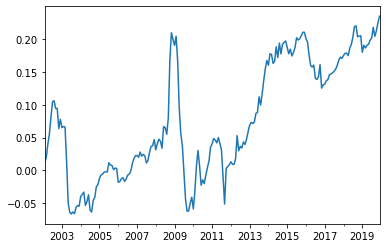

In [32]:
backtest.mean(axis = 1).cumsum().plot()

In [33]:
bt.factor_results(backtest, factor_model)

                            OLS Regression Results                            
Dep. Variable:              portfolio   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.585
Date:                Sun, 29 Nov 2020   Prob (F-statistic):              0.166
Time:                        13:00:46   Log-Likelihood:                 572.34
No. Observations:                 215   AIC:                            -1133.
Df Residuals:                     209   BIC:                            -1112.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF        -0.0708      0.034     -2.086      0.0

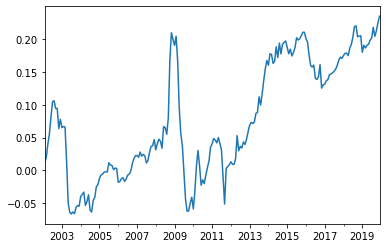

In [34]:
backtest.mean(axis = 1).cumsum().plot()

### Long only

                            OLS Regression Results                            
Dep. Variable:              portfolio   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     2.644
Date:                Sun, 29 Nov 2020   Prob (F-statistic):             0.0242
Time:                        14:02:34   Log-Likelihood:                 339.12
No. Observations:                 215   AIC:                            -666.2
Df Residuals:                     209   BIC:                            -646.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.2256      0.100      2.247      0.0

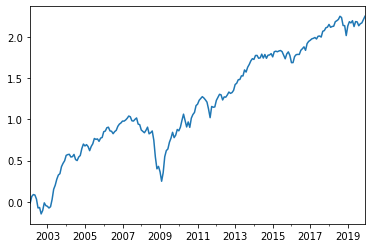

In [35]:
backtest, weights = bt.run_backtest(input_classifiers= ["Nearest Neighbors"], lookback_backtest = 12, inputs = feature_set, outputs = binary_returns,  ensemble = 'no', trade_type = 'long')
bt.factor_results(backtest, factor_model)
backtest.mean(axis = 1).cumsum().plot()

### Short only

                            OLS Regression Results                            
Dep. Variable:              portfolio   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     2.588
Date:                Sun, 29 Nov 2020   Prob (F-statistic):             0.0270
Time:                        15:04:09   Log-Likelihood:                 309.90
No. Observations:                 215   AIC:                            -607.8
Df Residuals:                     209   BIC:                            -587.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF        -0.2702      0.115     -2.349      0.0

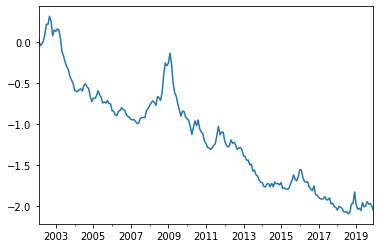

In [36]:
backtest, weights = bt.run_backtest(input_classifiers= ["Nearest Neighbors"], lookback_backtest = 12, inputs = feature_set, outputs = binary_returns,  ensemble = 'no', trade_type = 'short')
bt.factor_results(backtest, factor_model)
backtest.mean(axis = 1).cumsum().plot()

# Neural Net

In [37]:
backtest, weights = bt.run_backtest(input_classifiers= ["Neural Net"], lookback_backtest = 12, inputs = feature_set, outputs = binary_returns,  ensemble = 'no')

In [38]:
backtest.mean(axis = 1)

2002-02   -0.008173
2002-03    0.049457
2002-04    0.013857
2002-05   -0.001268
2002-06   -0.011895
2002-07   -0.047228
2002-08   -0.004144
2002-09   -0.022433
2002-10   -0.013558
2002-11   -0.041077
2002-12    0.013748
2003-01   -0.006763
2003-02    0.002914
2003-03    0.002360
2003-04   -0.017192
2003-05    0.008348
2003-06    0.014979
2003-07    0.046139
2003-08    0.038084
2003-09    0.013047
2003-10    0.073044
2003-11    0.033368
2003-12    0.026414
2004-01    0.058495
2004-02    0.012511
2004-03    0.002378
2004-04   -0.025498
2004-05    0.007107
2004-06    0.022969
2004-07   -0.037570
             ...   
2017-07    0.005922
2017-08    0.000503
2017-09    0.027006
2017-10    0.012621
2017-11    0.015082
2017-12   -0.000787
2018-01    0.019631
2018-02   -0.015458
2018-03    0.006167
2018-04    0.005262
2018-05    0.033079
2018-06    0.007122
2018-07    0.011956
2018-08    0.031236
2018-09   -0.007260
2018-10   -0.044733
2018-11    0.004762
2018-12   -0.030773
2019-01   -0.015470


                            OLS Regression Results                            
Dep. Variable:              portfolio   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     1.725
Date:                Mon, 30 Nov 2020   Prob (F-statistic):              0.130
Time:                        03:40:36   Log-Likelihood:                 503.99
No. Observations:                 215   AIC:                            -996.0
Df Residuals:                     209   BIC:                            -975.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF        -0.0172      0.047     -0.368      0.7

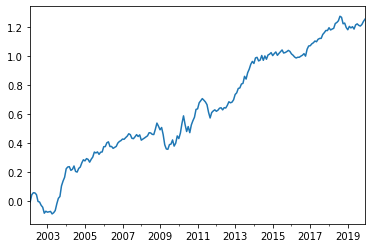

In [39]:
bt.factor_results(backtest, factor_model)
backtest.mean(axis = 1).cumsum().plot()

In [40]:
factor_model.mean(axis = 1).mean() / factor_model.mean(axis = 1).std()
backtest.mean(axis = 1).mean() / backtest.mean(axis = 1).std()

0.24590492587627025

### Long only

                            OLS Regression Results                            
Dep. Variable:              portfolio   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     2.782
Date:                Mon, 30 Nov 2020   Prob (F-statistic):             0.0187
Time:                        16:12:10   Log-Likelihood:                 347.23
No. Observations:                 215   AIC:                            -682.5
Df Residuals:                     209   BIC:                            -662.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.2174      0.097      2.249      0.0

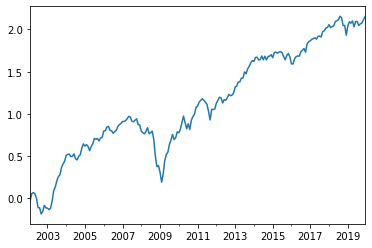

In [41]:
backtest, weights = bt.run_backtest(input_classifiers= ["Neural Net"], lookback_backtest = 12, inputs = feature_set, outputs = binary_returns,  ensemble = 'no', trade_type = 'long')
bt.factor_results(backtest, factor_model)
backtest.mean(axis = 1).cumsum().plot()

### Short only

                            OLS Regression Results                            
Dep. Variable:              portfolio   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     2.473
Date:                Tue, 01 Dec 2020   Prob (F-statistic):             0.0335
Time:                        04:41:56   Log-Likelihood:                 275.90
No. Observations:                 215   AIC:                            -539.8
Df Residuals:                     209   BIC:                            -519.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF        -0.3111      0.135     -2.309      0.0

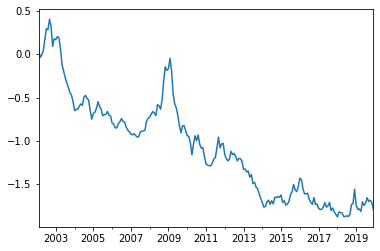

In [42]:
backtest, weights = bt.run_backtest(input_classifiers= ["Neural Net"], lookback_backtest = 12, inputs = feature_set, outputs = binary_returns,  ensemble = 'no', trade_type = 'short')
bt.factor_results(backtest, factor_model)
backtest.mean(axis = 1).cumsum().plot()

# Random Forest

In [43]:
backtest, weights = bt.run_backtest(input_classifiers= ["Random Forest"], lookback_backtest = 12, inputs = feature_set, outputs = binary_returns,  ensemble = 'no')

                            OLS Regression Results                            
Dep. Variable:              portfolio   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.212
Date:                Tue, 01 Dec 2020   Prob (F-statistic):              0.305
Time:                        05:50:25   Log-Likelihood:                 543.54
No. Observations:                 215   AIC:                            -1075.
Df Residuals:                     209   BIC:                            -1055.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF        -0.0843      0.039     -2.173      0.0

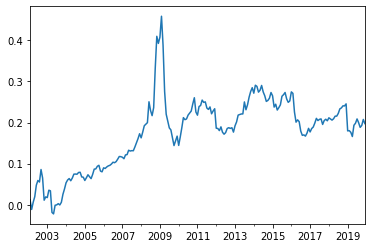

In [44]:
bt.factor_results(backtest, factor_model)
backtest.mean(axis = 1).cumsum().plot()

### Long Only

                            OLS Regression Results                            
Dep. Variable:              portfolio   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     2.824
Date:                Tue, 01 Dec 2020   Prob (F-statistic):             0.0172
Time:                        06:57:44   Log-Likelihood:                 347.83
No. Observations:                 215   AIC:                            -683.7
Df Residuals:                     209   BIC:                            -663.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.2191      0.096      2.272      0.0

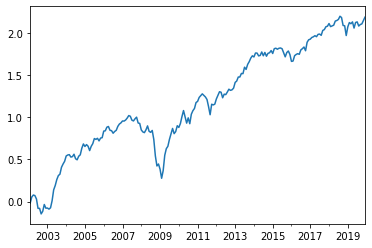

In [45]:
backtest, weights = bt.run_backtest(input_classifiers= ["Random Forest"], lookback_backtest = 12, inputs = feature_set, outputs = binary_returns,  ensemble = 'no', trade_type = 'long')
bt.factor_results(backtest, factor_model)
backtest.mean(axis = 1).cumsum().plot()

### Short Only

                            OLS Regression Results                            
Dep. Variable:              portfolio   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     2.637
Date:                Tue, 01 Dec 2020   Prob (F-statistic):             0.0246
Time:                        08:04:51   Log-Likelihood:                 305.69
No. Observations:                 215   AIC:                            -599.4
Df Residuals:                     209   BIC:                            -579.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF        -0.2726      0.117     -2.325      0.0

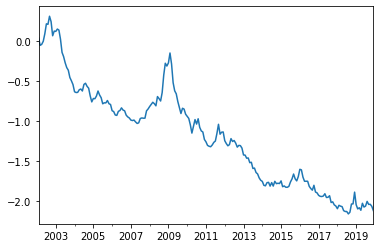

In [46]:
backtest, weights = bt.run_backtest(input_classifiers= ["Random Forest"], lookback_backtest = 12, inputs = feature_set, outputs = binary_returns,  ensemble = 'no', trade_type = 'short')
bt.factor_results(backtest, factor_model)
backtest.mean(axis = 1).cumsum().plot()

# Ensemble System

In [47]:
backtest, weights = bt.run_backtest(input_classifiers= ["Nearest Neighbors", "Random Forest"], lookback_backtest = 12, inputs = feature_set, outputs = binary_returns,  ensemble = 'yes')

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
bt.factor_results(backtest, factor_model)
backtest.mean(axis = 1).cumsum().plot()

In [ ]:
for var in factor_model.columns:
    plot_df = pd.concat([backtest[var].cumsum(), weights[var]], axis = 1)
    plot_df.columns = ['backtest', 'signal']
    plot_df.plot()
    returns.loc[weights.index, var].cumsum().plot(legend = True)

# Analyze the Market with New Factor

In [ ]:
bt.check_new_factor(backtest, factor_model, index_symbol)

# Simple Binary Decision

In [ ]:
df_alpha_shift = df_alpha.shift(1).dropna(axis = 0)
backtest = returns.loc[df_alpha_shift.index]
weights = returns.loc[df_alpha_shift.index]
for count, row in  backtest.iterrows(): 
    for j in backtest.columns:
        if df_alpha_shift.loc[count, j] >= 0:
            backtest.loc[count, j] = backtest.loc[count, j]
            weights.loc[count, j] = 1.0
        else:
            backtest.loc[count, j] = -backtest.loc[count, j]
            weights.loc[count, j] = -1.0

In [ ]:
backtest.mean(axis = 1).cumsum().plot()

In [ ]:
for var in factor_model.columns:
    plot_df = pd.concat([backtest[var].cumsum(), weights[var]], axis = 1)
    plot_df.columns = ['backtest', 'signal']
    plot_df.plot()
    returns.loc[weights.index, var].cumsum().plot(legend = True)

In [ ]:
bt.factor_results(backtest, factor_model)

In [ ]:
bt.check_new_factor(backtest, factor_model, index_symbol)